# Purpose: To Test the Sci-kit Image Thresholds for the Landry Collab Images

Date Created: October 12th, 2021

Dates Edited: October 12th, 2021 - Converted from the original notebook for the microFIBER paper

October 27th, 2021 - Downloaded all the .tiff files and changed the imports

*Step 1: Import necessary packages*

In [26]:
#import operating system
import os

# import major packages
import numpy as np
import matplotlib.pyplot as plt
import skimage
import PIL as Image

Separating the two imports so that it is a cleaner workflow

In [27]:
# import specific package functions
from skimage import io
from skimage.filters import try_all_threshold
from skimage.filters import threshold_isodata
from skimage.filters import threshold_li
from skimage.filters import threshold_mean
from skimage.filters import threshold_minimum
from skimage.filters import threshold_otsu
from skimage.filters import threshold_triangle
from skimage.filters import threshold_yen

from skimage import morphology
from scipy import ndimage
from skimage.measure import label

## Phuong's Data Set

*Step 2: Import image for testing thresholds*

In [28]:
#Defining the local folder location for all files
im_folder_location = '/Users/hhelmbre/Desktop/Phuong_Bev'

In [29]:
def folder_cleaner(folder, image_type):
    k=0
    for files in folder:
        if image_type in str(files):
            k+=1
        else:
            folder = np.delete(folder, np.argwhere(folder == str(files)))
    return folder

In [30]:
#Getting a list of all the seprate animal model folders
arr = os.listdir(im_folder_location)
animal_list = np.asarray(arr)

#Since I am working on a mac operating system, this removes the DS_store file
animal_list = animal_list[1:]
animal_list

array(['4_hr_exposure_0_hr_application_tifs',
       '24_hr_exposure_0_hr_application_tifs',
       '48h_exposure_0hr_application tifs', 'Healthy_OGD_Controls tif'],
      dtype='<U36')

In [33]:
#Getting a list of all the images we want to run and test thresholds on
try_all_im_list = []
for folders in animal_list:
    sub_folder_location = str(im_folder_location + '/' + folders)
    arr = os.listdir(sub_folder_location)
    image_list = np.asarray(arr)
    image_list = [ x for x in image_list if "TILE" not in x ]
    image_list = [ x for x in image_list if "all_thresh" not in x ]
    image_list = [x for x in image_list if ".tif" in x]
    for images in image_list:
        file_name = str(im_folder_location + '/' + folders + '/' + images)
        try_all_im_list.append(file_name)

try_all_im_list

['/Users/hhelmbre/Desktop/Phuong_Bev/4_hr_exposure_0_hr_application_tifs/EV_MICROGLIA_STUDY_OGD_CONTROL_1-2-3-2.tif',
 '/Users/hhelmbre/Desktop/Phuong_Bev/4_hr_exposure_0_hr_application_tifs/EV_MICROGLIA_STUDY_OGD_CONTROL_1-2-3-3.tif',
 '/Users/hhelmbre/Desktop/Phuong_Bev/4_hr_exposure_0_hr_application_tifs/EV_MICROGLIA_STUDY_OGD_CONTROL_1-2-1-1.tif',
 '/Users/hhelmbre/Desktop/Phuong_Bev/4_hr_exposure_0_hr_application_tifs/EV_MICROGLIA_STUDY_HEALTHY_CONTROL_1-2-1-8.tif',
 '/Users/hhelmbre/Desktop/Phuong_Bev/4_hr_exposure_0_hr_application_tifs/EV_MICROGLIA_STUDY_OGD_CONTROL_1-2-1-3.tif',
 '/Users/hhelmbre/Desktop/Phuong_Bev/4_hr_exposure_0_hr_application_tifs/EV_MICROGLIA_STUDY_OGD_CONTROL_1-2-3-1.tif',
 '/Users/hhelmbre/Desktop/Phuong_Bev/4_hr_exposure_0_hr_application_tifs/EV_MICROGLIA_STUDY_OGD_CONTROL_1-2-1-2.tif',
 '/Users/hhelmbre/Desktop/Phuong_Bev/4_hr_exposure_0_hr_application_tifs/EV_MICROGLIA_STUDY_OGD_CONTROL_1-2-1-6.tif',
 '/Users/hhelmbre/Desktop/Phuong_Bev/4_hr_exposure_0

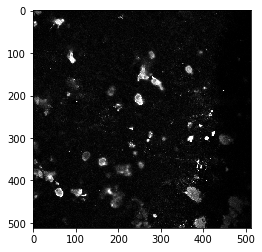

In [34]:
#Testing which channel the iba stain is on
im = io.imread(try_all_im_list[0])
green_im = im[:,:,1]
plt.imshow(green_im, cmap='Greys_r')

*Step 3: Trying multiple tresholds at once and saving the composite image*

In [37]:
j = 0 #initialize a counter
for images in try_all_im_list:
    im_name = try_all_im_list[j]
    im = io.imread(im_name)
    microglia_im = im[:,:,1]
    fig, ax = try_all_threshold(microglia_im, figsize=(10, 8), verbose=False)

    
    j += 1
    fig_name = str(im_name[:-4] + '_all_thresh.tif')
    fig.savefig(fig_name)
    plt.close('all')
    print(j)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219


*Move all images with try_all_thresh into their own folder*

In [53]:
import shutil
import os

source_dir = '/Users/hhelmbre/Desktop/Phuong_Bev/Healthy_OGD_Controls_tif'
target_dir = '/Users/hhelmbre/Desktop/Phuong_Bev/try_all_thresh'

arr = os.listdir(source_dir)
file_list = np.asarray(arr)

file_list = [x for x in file_list if "all_thresh" in x]

    
for file_name in file_list:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

*Step 4: Based on visual inspection of the try all thresholds, Li threshold does the best*

To determine the size of the small object we should remove we took the size of microglia which are approximately 1600 um^2 according to (https://jneuroinflammation.biomedcentral.com/articles/10.1186/s12974-014-0182-7)

The confocal settings for the OGD severity study provided a 1 pixel = 3.4527 um conversion. To ensure we didn't cut off any potential microglia, we chose a cutoff on the small end to be 1/2 of the average which converts to 71 pixels ^2 used in the min_size of the remove small objects function from sci-kit image.

In [71]:
im_folder_location = '/Users/hhelmbre/Desktop/Phuong_Bev'

#Getting a list of all the seprate animal model folders
arr = os.listdir(im_folder_location)
animal_list = np.asarray(arr)

#Since I am working on a mac operating system, this removes the DS_store file
animal_list = animal_list[1:]
animal_list = folder_cleaner(animal_list, 'tif')

#Getting a list of all the images we want to run and test thresholds on
try_all_im_list = []
for folders in animal_list:
    sub_folder_location = str(im_folder_location + '/' + folders)
    arr = os.listdir(sub_folder_location)
    image_list = np.asarray(arr)
    image_list = [ x for x in image_list if "TILE" not in x ]
    image_list = [ x for x in image_list if "all_thresh" not in x ]
    image_list = [x for x in image_list if ".tif" in x]
    for images in image_list:
        file_name = str(im_folder_location + '/' + folders + '/' + images)
        try_all_im_list.append(file_name)

In [72]:
#li threshold
k = 0
source_dir = '/Users/hhelmbre/Desktop/Phuong_Bev/'

for images in try_all_im_list:
    im_name = try_all_im_list[k]
    im = io.imread(im_name)
    microglia_im = im[:,:,1]
    thresh_li = skimage.filters.threshold_li(microglia_im)
    binary_li = microglia_im > thresh_li
    new_binary_li = morphology.remove_small_objects(binary_li, min_size=71)
    new_binary_li = ndimage.binary_fill_holes(new_binary_li)
    
    short_im_name = im_name.split('/')[6]

    np.save(str(source_dir + 'li_thresh/' + short_im_name[:-4] + '_li_thresh'), new_binary_li)
    
    print(k)
    k += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
